## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [11]:
from fastai.vision import *
from fastai.metrics import error_rate

import cv2
import numpy as np
import os
import multiprocessing

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Constants

In [3]:
bs = 64
np.random.seed(42)
folder = '../data/demo_mortar'
filenames = ['makerspace', 'wall', 'carpet', 'hall', 'outside']

## Split videos

In [57]:

# Playing video from file:

source_path = '../data/demo_mortar/makerspace.mp4'

def split_video(folder, filename, split=(2000, 3000, 3500), filetype='.mp4'):
    total_f_name = os.path.join(folder, filename + filetype)
    print(f'Splitting {total_f_name} with split {split}')
    
    cap = cv2.VideoCapture(total_f_name)

    os.makedirs(os.path.join(folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'val'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'test'), exist_ok=True)

    currentFrame = 0
    success = True

    while(success):
        # Capture frame-by-frame
        success, frame = cap.read()

        # Saves image of the current frame in jpg file
        if (currentFrame <= split[0]):
            subfolder = 'train'
        if (split[0] < currentFrame <= split[1]):
            subfolder = 'val'
        if (split[1] < currentFrame):
            subfolder = 'test'
        if (split[2] < currentFrame):  # stop generation
            break
            
        name = os.path.join(folder, subfolder, filename + str(currentFrame) + '.jpg')
#         print ('Creating: ' + name)
        cv2.imwrite(name, frame)

        # To stop duplicate images
        currentFrame += 1

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
    if currentFrame < split[2]:
        print('ERROR, not enough frames!')
    else:
        print(f'{total_f_name} is done')
    
def create_dataset(folder, filenames, split=(2000, 3000, 3500), filetype='.mp4'):
    n = len(filenames)
    iter_over = list(zip([folder] * n, filenames, [split] * n, [filetype] * n))
    with multiprocessing.Pool(processes=len(filenames)) as pool:
        pool.starmap(split_video, iter_over)
        pool.join()
        pool.close()
        
    
create_dataset(folder, filenames)

Splitting ../data/demo_mortar/outside.mp4 with split (2000, 3000, 3500)
Splitting ../data/demo_mortar/carpet.mp4 with split (2000, 3000, 3500)
Splitting ../data/demo_mortar/makerspace.mp4 with split (2000, 3000, 3500)
Splitting ../data/demo_mortar/wall.mp4 with split (2000, 3000, 3500)
Splitting ../data/demo_mortar/hall.mp4 with split (2000, 3000, 3500)


Process ForkPoolWorker-838:
Traceback (most recent call last):
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-57-641c86c4f3dd>", line 20, in split_video
    success, frame = cap.read()
KeyboardInterrupt
Process ForkPoolWorker-840:
Traceback (most recent call last):
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jakub/anaconda3/envs/devel/lib/python3.7/multiproces

KeyboardInterrupt: 

## Load the data

In [58]:
re_string = '(' + '|'.join(filenames) + ')'
print(re_string)
# re_string = '(\w+)\d+.jpg'

data = (ImageList.from_folder(folder)
                     .split_by_folder('train', 'val')
                     .label_from_re(re_string)
                     .add_test_folder('test')
                     .transform(get_transforms(), size=(1080//4, 1920//4), tfm_y=False)
                     .databunch(bs=bs)
                     .normalize(imagenet_stats))
data

(makerspace|wall|carpet|hall|outside)


ImageDataBunch;

Train: LabelList (10005 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
wall,carpet,wall,carpet,makerspace
Path: ../data/demo_mortar;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
hall,makerspace,carpet,wall,carpet
Path: ../data/demo_mortar;

Test: LabelList (2500 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: EmptyLabelList
,,,,
Path: ../data/demo_mortar

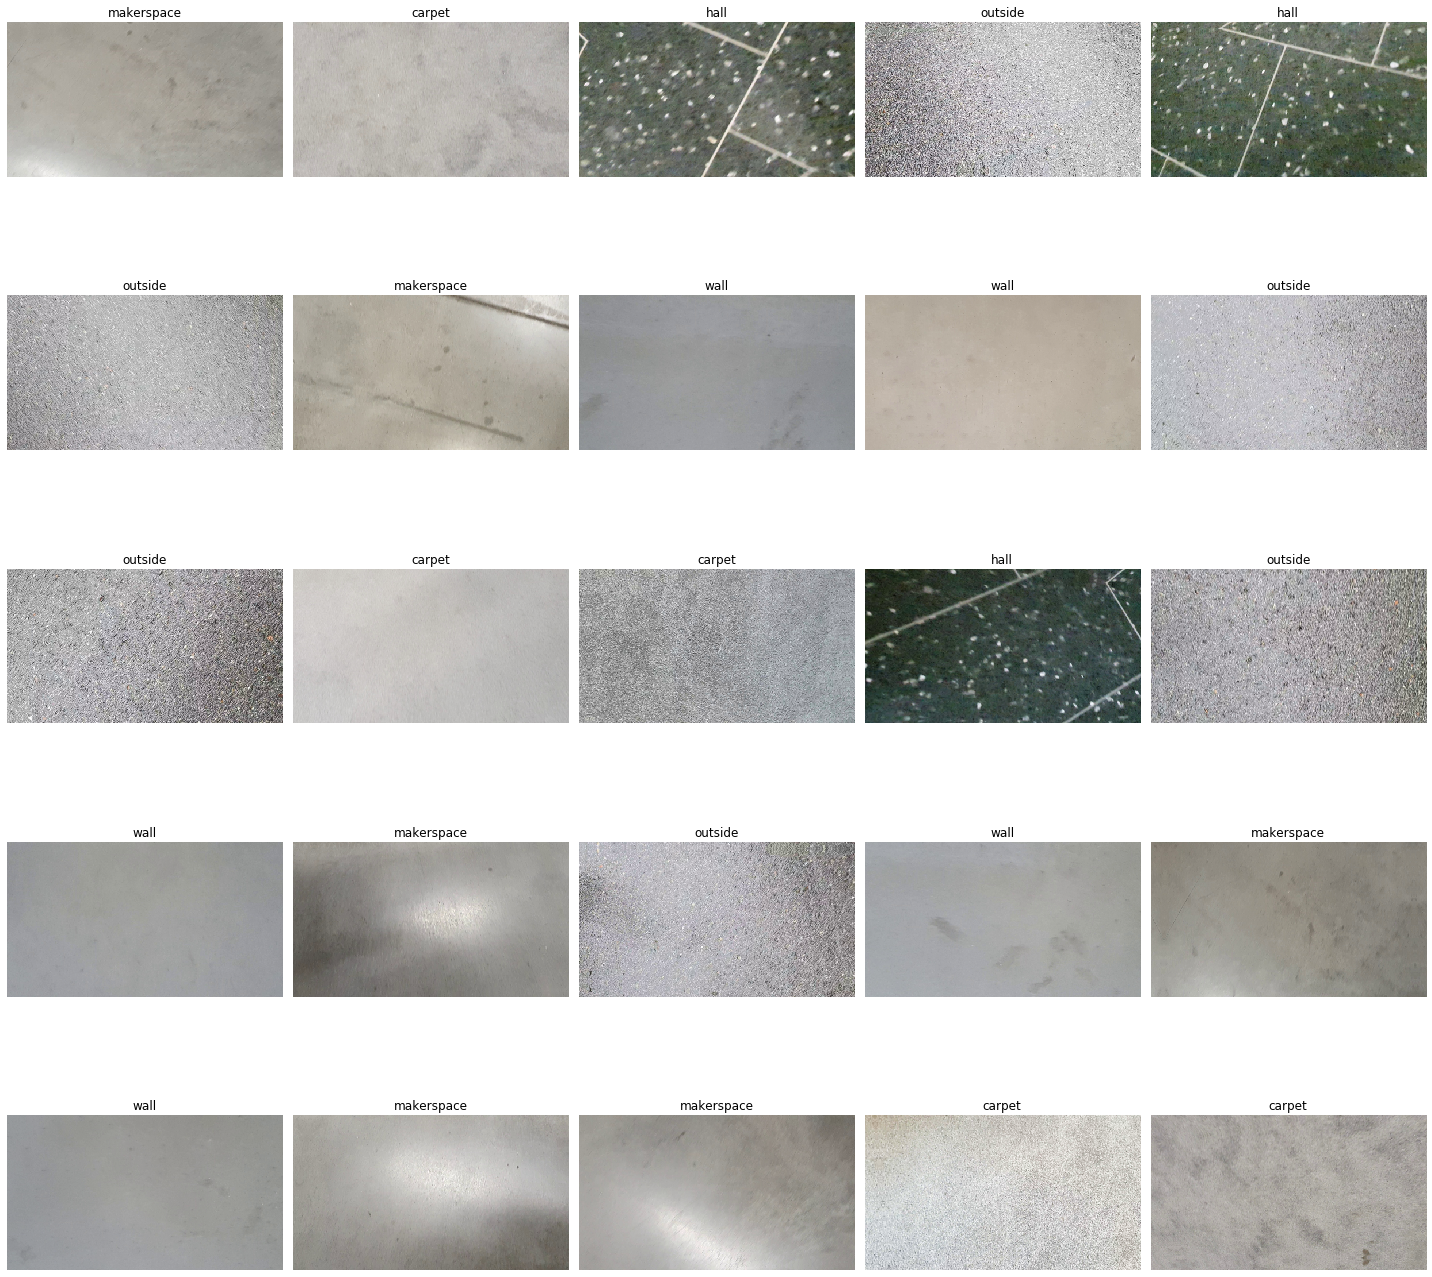

In [59]:
# Look at the data
data.show_batch()

# Training

In [60]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


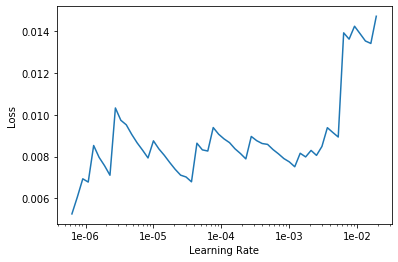

In [15]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.130530,0.730441,0.192400,03:22
1,0.271433,0.253617,0.071000,03:24
2,0.076104,0.214275,0.063400,03:22
3,0.041337,0.234454,0.064000,03:22
4,0.022485,0.206256,0.057800,03:24
5,0.020818,0.198217,0.057000,03:21
6,0.018029,0.265853,0.063400,03:21


In [ ]:
learn.save('stage-1')

### Hand evaluation

In [ ]:
from IPython import display

def evaluate_model(model):
    interp = ClassificationInterpretation.from_learner(model)

    losses,idxs = interp.top_losses()

    print(len(data.valid_ds)==len(losses)==len(idxs))
    
#     display(interp.plot_confusion_matrix(figsize=(12,12), dpi=60, return_fig=True))
#     interp.plot_confusion_matrix(figsize=(12,12), dpi=60, return_fig=True)
    
    print(interp.most_confused(min_val=2))
    
    interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
    interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

evaluate_model(learn)

## Unfreeze, train a bit more

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1)

In [ ]:
evaluate_model(learn)

# Web service